# Практическое задание № 2. Вариант 3.
#### Решается линейная система $Ax = b$ методом SOR. 

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

warnings.filterwarnings('ignore')

##### 1. SOR-метод.

In [245]:
def SOR(A, b, omega, eps=1e-8, max_iter=1000):
    n = A.shape[0]
    x = np.zeros(n)

    for it in range(max_iter):
        x_old = x.copy()
        for i in range(n):
            sigma = np.dot(A[i, :i], x[:i]) + np.dot(A[i, i+1:], x_old[i+1:])
            x[i] = (1 - omega) * x_old[i] + (omega / A[i, i]) * (b[i] - sigma)
        if np.linalg.norm(x - x_old) < eps:
            return x, it+1
    return x, max_iter

##### 2. Показать зависимость скорости сходимости с выбором $\omega$. Проверить эффективность предложенного выбора параметра с семинара (для матриц с известным спектром). Подтвердить результат графиками.

In [246]:
def generate_spd_matrix(n, diag_dom=100.0):
    M = np.random.randn(n, n)
    return np.dot(M.T, M) + diag_dom * np.eye(n)


def compute_sperctral_radius_of_jacobi_iteration_matrix(A):
    return abs(max(np.linalg.eigvals(-np.dot(np.diag(1 / np.diag(A)), (np.tril(A, k=-1) + np.triu(A, k=1))))))


In [247]:
n = 100

b = np.random.randn(n)
A = generate_spd_matrix(n, diag_dom=1000.0)

rho = compute_sperctral_radius_of_jacobi_iteration_matrix(A)

if rho >= 1:
    print("Метод не сходится. Спектральный радиус:", rho)
    omega_opt = None
else:
    omega_opt = 2 / (1 + np.sqrt(1 - rho**2))
    print("Оптимальный параметр релаксации:", omega_opt)

Оптимальный параметр релаксации: 1.0025130615649243


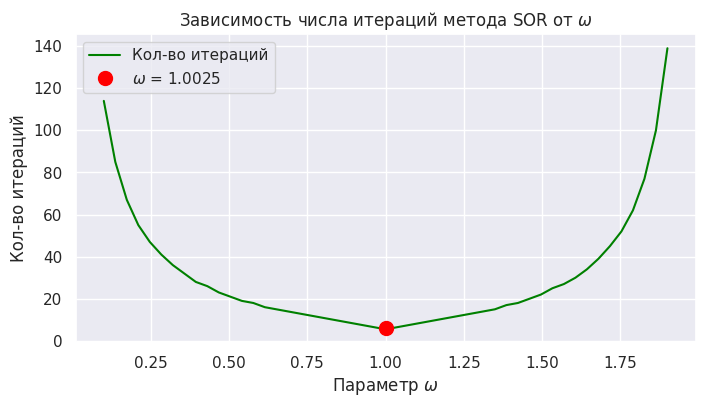

In [248]:
omegas = np.linspace(0.1, 1.9, 50)
iters = []

for omega in omegas:
    iters.append(SOR(A, b, omega, eps=1e-8, max_iter=1000)[1])


with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(8,4))
    plt.plot(omegas, iters, color="g", label="Кол-во итераций")
    if omega_opt is not None and 0.1 <= omega_opt <= 1.9:
        opt_iter = SOR(A, b, omega_opt, eps=1e-8, max_iter=1000)[1]
        plt.plot(omega_opt, opt_iter, 'ro', markersize=10, label=f"$\omega$ = {omega_opt:.4f}")
    plt.xlabel("Параметр $\omega$")
    plt.ylabel("Кол-во итераций")
    plt.title("Зависимость числа итераций метода SOR от $\omega$")
    plt.legend()

##### 3. Построить графики в лог-лог шкалах для матриц с разной обусловленностью. На графиках должно быть чётко видно разделение качества сходимости. Генерируйте матрицы с ограниченым числом обусловленности!

In [249]:
def generate_spd_matrix_with_given_conditionality(n, cond):
    M = np.random.randn(n, n)
    Q, R = np.linalg.qr(M)
    return Q @ np.diag(np.linspace(1, cond, n)) @ Q.T  # матрица с нужным чисоом обусловленности

In [250]:
omegas = np.linspace(0.1, 1.99, 50)
conds = [10, 100, 1000, 10000]
spectral_radii = []
optimal_omegas = []
optimal_iters = []
results = {}

for cond in conds:
    A = generate_spd_matrix_with_given_conditionality(n, cond)
    b = np.random.randn(n)
    spectral_radii.append(compute_sperctral_radius_of_jacobi_iteration_matrix(A))
    if spectral_radii[-1] >= 1:
        print("Метод не сходится. Спектральный радиус при числе обусловленности", cond, "равен", spectral_radii[-1])
        optimal_omegas.append(None)
    else:
        optimal_omegas.append(2 / (1 + np.sqrt(1 - spectral_radii[-1] ** 2)))
        print("Оптимальный параметр релаксации при числе обусловленности", cond, "равен", optimal_omegas[-1])
    iter_counts = []
    for omega in omegas:
        _, iters = SOR(A, b, omega)
        iter_counts.append(iters)
    results[cond] = np.array(iter_counts)

    optimal_iters.append(SOR(A, b, optimal_omegas[-1])[1])

Оптимальный параметр релаксации при числе обусловленности 10 равен 1.2660988039586423
Оптимальный параметр релаксации при числе обусловленности 100 равен 1.6659783080851371
Оптимальный параметр релаксации при числе обусловленности 1000 равен 1.881027790412385
Оптимальный параметр релаксации при числе обусловленности 10000 равен 1.9604969452627055


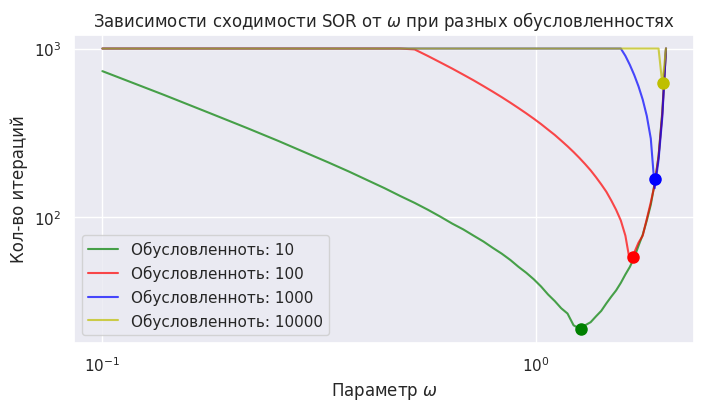

In [251]:
colors = ["g", "r", "b", "y"]

with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(8, 4))
    for it, cond in enumerate(conds):
        plt.loglog(omegas, results[cond], color=colors[it], label=f'Обусловленноть: {cond}', alpha=0.7)
        if optimal_omegas[it] is not None and 0.1 <= optimal_omegas[it] <= 1.99:
            _, opt_iter = SOR(A, b, optimal_omegas[it])
            plt.loglog(optimal_omegas[it], optimal_iters[it], str(colors[it])+'o', markersize=8)
    plt.xlabel('Параметр $\omega$')
    plt.ylabel('Кол-во итераций')
    plt.title('Зависимости сходимости SOR от $\omega$ при разных обусловленностях')
    plt.legend()


##### 4. Сравнить все методы с linalg.solve

In [252]:
for it, cond in enumerate(conds):
    A = generate_spd_matrix_with_given_conditionality(n, cond)
    b = np.random.randn(n)
    spectral_radus = compute_sperctral_radius_of_jacobi_iteration_matrix(A)
    optimal_omega = 2 / (1 + np.sqrt(1 - spectral_radii[-1] ** 2))
    
    start_sor = time.time()
    x_sor, iter_sor = SOR(A, b, optimal_omega)
    end_sor = time.time()
    time_sor = end_sor - start_sor

    start_np = time.time()
    x_np = np.linalg.solve(A, b)
    end_np = time.time()
    time_np = end_np - start_np
    
    print(f"Число обусловленности {cond}: ")
    print(f"    Время SOR: {time_sor * 1e3:.4f} миллисекунд(ы)")
    print(f"    Время  np:  {time_np * 1e3:.4f} миллисекунд(ы)")

Число обусловленности 10: 
    Время SOR: 73.5610 миллисекунд(ы)
    Время  np:  0.0927 миллисекунд(ы)
Число обусловленности 100: 
    Время SOR: 50.7569 миллисекунд(ы)
    Время  np:  0.0939 миллисекунд(ы)
Число обусловленности 1000: 
    Время SOR: 43.4098 миллисекунд(ы)
    Время  np:  0.0541 миллисекунд(ы)
Число обусловленности 10000: 
    Время SOR: 41.2488 миллисекунд(ы)
    Время  np:  0.0901 миллисекунд(ы)


##### 5. Показать существенность выбора предобуславливания.


In [253]:
def SOR_preconditioned(A, b, omega, eps=1e-8, max_iter=1000):
    n = A.shape[0]
    x = np.zeros(n)
    
    P_inv = np.diag(1.0 / np.diag(A))
    A_tilde = P_inv @ A
    b_tilde = P_inv @ b
    
    for it in range(max_iter):
        x_old = x.copy()
        for i in range(n):
            sigma = np.dot(A_tilde[i, :i], x[:i]) + np.dot(A_tilde[i, i+1:], x_old[i+1:])
            x[i] = (1 - omega) * x_old[i] + (omega / A_tilde[i, i]) * (b_tilde[i] - sigma)
        if np.linalg.norm(x - x_old, ord=np.inf) < eps:
            return x, it + 1
    return x, max_iter

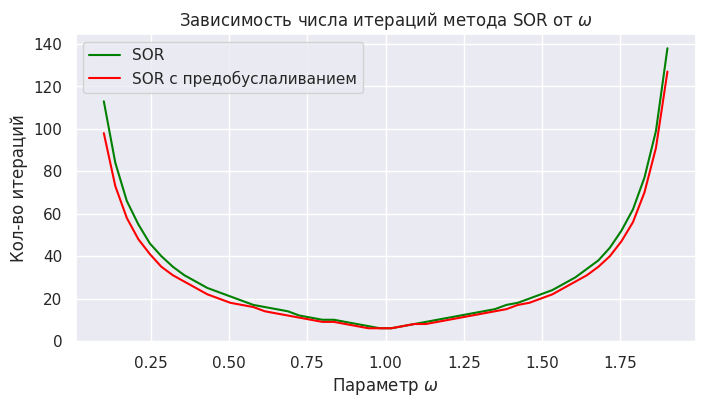

In [256]:
b = np.random.randn(n)
A = generate_spd_matrix(n, diag_dom=1000.0)

omegas = np.linspace(0.1, 1.9, 50)
iters = []
iters_prec = []

for omega in omegas:
    iters.append(SOR(A, b, omega, eps=1e-8, max_iter=1000)[1])
    iters_prec.append(SOR_preconditioned(A, b, omega, eps=1e-8, max_iter=1000)[1])


with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(8,4))
    plt.plot(omegas, iters, color="g", label="SOR")
    plt.plot(omegas, iters_prec, color="r", label="SOR с предобуслаливанием")
    plt.xlabel("Параметр $\omega$")
    plt.ylabel("Кол-во итераций")
    plt.title("Зависимость числа итераций метода SOR от $\omega$")
    plt.legend()

In [257]:
omegas = np.linspace(0.1, 1.99, 50)
conds = [10, 100, 1000, 10000]

results = {}
results_prec = {}

for cond in conds:
    A = generate_spd_matrix_with_given_conditionality(n, cond)
    b = np.random.randn(n)
    
    iter_counts = []
    iter_counts_prec = []
    for omega in omegas:
        iter_counts.append(SOR(A, b, omega)[1])
        iter_counts_prec.append(SOR_preconditioned(A, b, omega)[1])
    results[cond] = np.array(iter_counts)
    results_prec[cond] = np.array(iter_counts_prec)

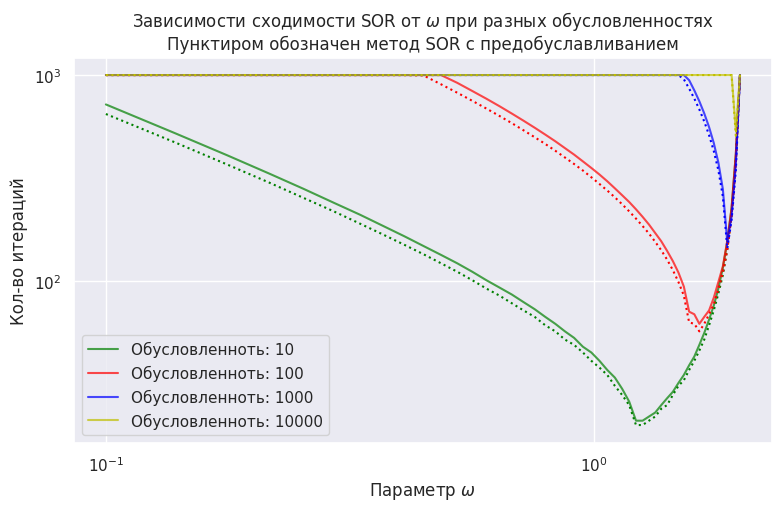

In [262]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 5))
    for it, cond in enumerate(conds):
        plt.loglog(omegas, results[cond], color=colors[it], label=f'Обусловленноть: {cond}', alpha=0.7)
        plt.loglog(omegas, results_prec[cond], color=colors[it], linestyle=":")
    plt.xlabel('Параметр $\omega$')
    plt.ylabel('Кол-во итераций')
    plt.title('Зависимости сходимости SOR от $\omega$ при разных обусловленностях\nПунктиром обозначен метод SOR с предобуславливанием')
    plt.legend()